In [226]:
import sys
sys.path.insert(0, '..')

In [227]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [228]:
wid = 64
oversample = 4

nwavels = 30
npoly=5

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    'n8yj53vfq_cal.fits'

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]

exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj53vfq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.1
Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj53vfq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageH

In [229]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    #"rot": 0.,
    "softening": 2.,
    "bias": {},
    "jitter": {},
    #"displacement": 0.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([6., 6.])#*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

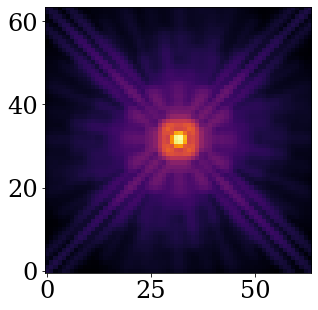

In [230]:
plt.imshow(exposures_single[0].fit(model_single,exposures_single[0])**0.125)

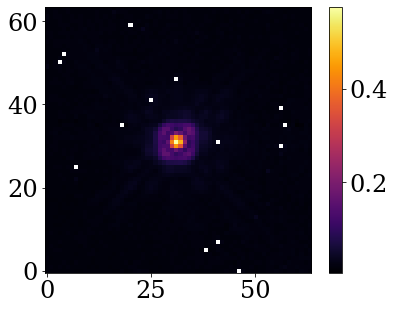

In [231]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

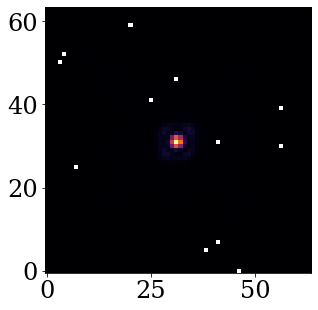

In [232]:
plt.imshow(exposures_single[0].data)

In [233]:
np.nanmin(exposures_single[0].err)

Array(0.00728341, dtype=float32)

In [234]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

In [235]:
loss_fn(params, exposures_single, model_single)

Array(476790.25, dtype=float32)

In [236]:
#potat

In [237]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*50, 0),
    "spectrum": opt(g*50, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*50, 20),
    #"cold_mask_rot": opt(g*2000, 50),
    "bias": opt(g*30, 60),
    "aberrations": opt(g*2,80, (500, 2)),#, (150, g*0.2)),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [238]:
losses, models = optimise(params, model_single, exposures_single, things, 500)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[[2023604.9   211750.55]
 [ 211750.6  2335895.2 ]]
[[20959408.     -434801.88   7388815.     -213144.81   4732003.   ]
 [ -434801.12   2204729.5    -222701.03   1350804.     -156997.88 ]
 [ 7388816.     -222700.88   3159455.8    -124948.56   2169579.2  ]
 [ -213144.4    1350804.     -124948.59    981180.75    -91479.375]
 [ 4732003.     -156998.03   2169579.5     -91479.625  1560894.6  ]]
[[-37444.824   4233.363]
 [  4233.364 -37332.81 ]]
[[8621098.]]
[[-2.78154812e+01 -4.79232937e-01  5.83040810e+00  1.33302822e+01
  -1.10334196e+01  5.90733469e-01  2.83152604e+00  2.38315678e+00
   5.77950895e-01 -8.62182236e+00 -1.42535698e+00 -9.58560526e-01
  -1.67109222e+01  1.71873436e+01 -3.89412785e+00 -5.92748165e+00
   1.61053920e+00 -1.40098023e+00  2.98411407e+01  2.72354364e+00
  -2.36143994e+00 -6.95972890e-02 -1.61928785e+00  5.25200069e-01
   7.27056026e-01 -5.77877855e+00]
 [-4.79224950e-01 -2.59747200e+01 -2.28854465e+00 -7.06104946e+00
   6.28420067e+00 -5.16128635e+00 -5.51062059e+

  0%|          | 0/500 [00:00<?, ?it/s]

In [241]:
losses[-1]

Array(1675.5132, dtype=float32)

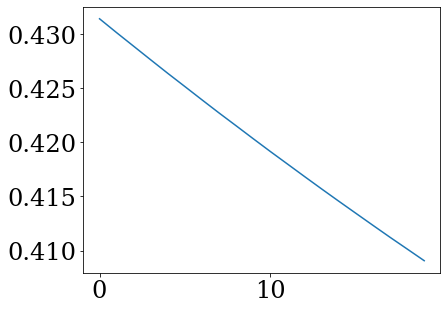

In [239]:
plt.plot(np.asarray(losses[-20:])/wid**2)

5


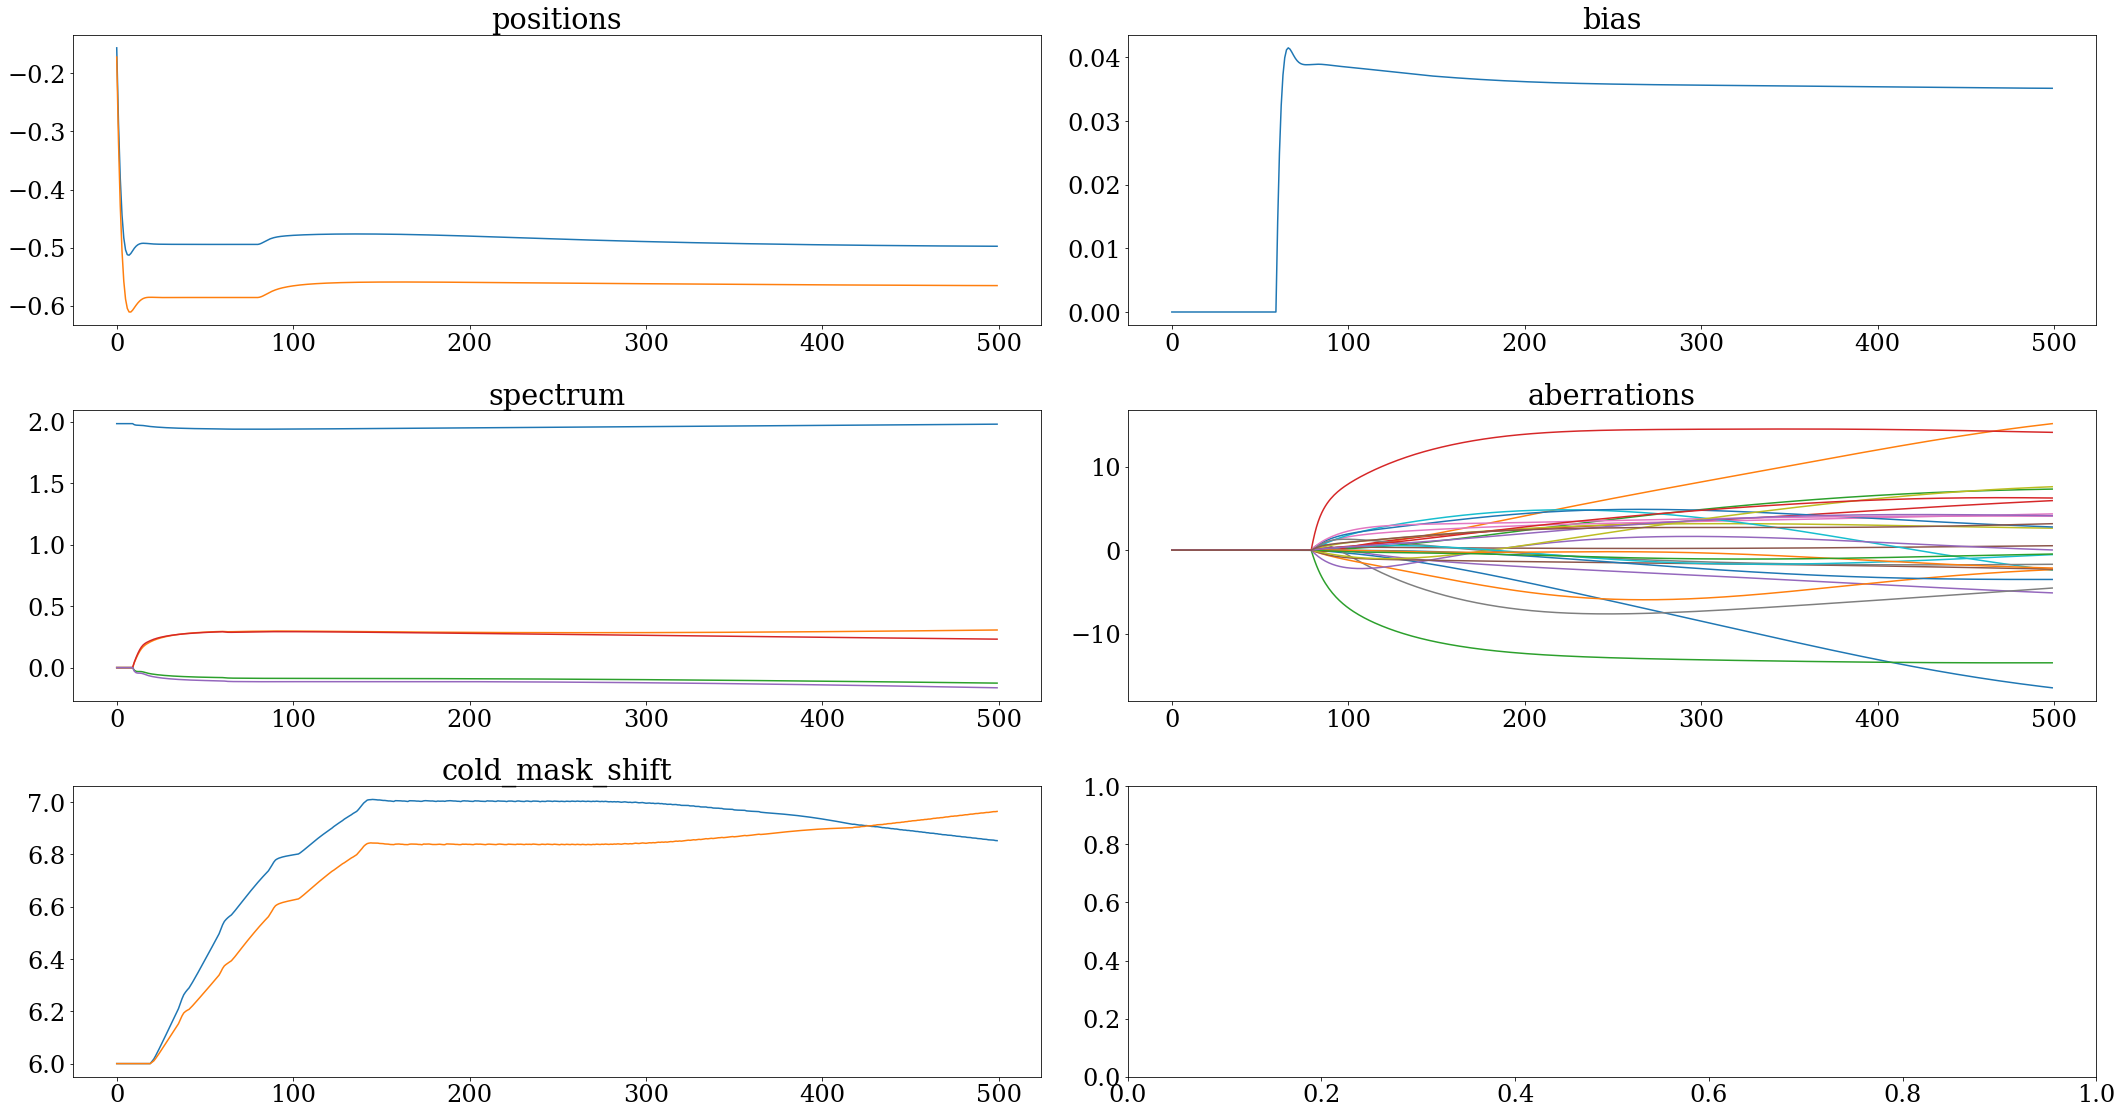

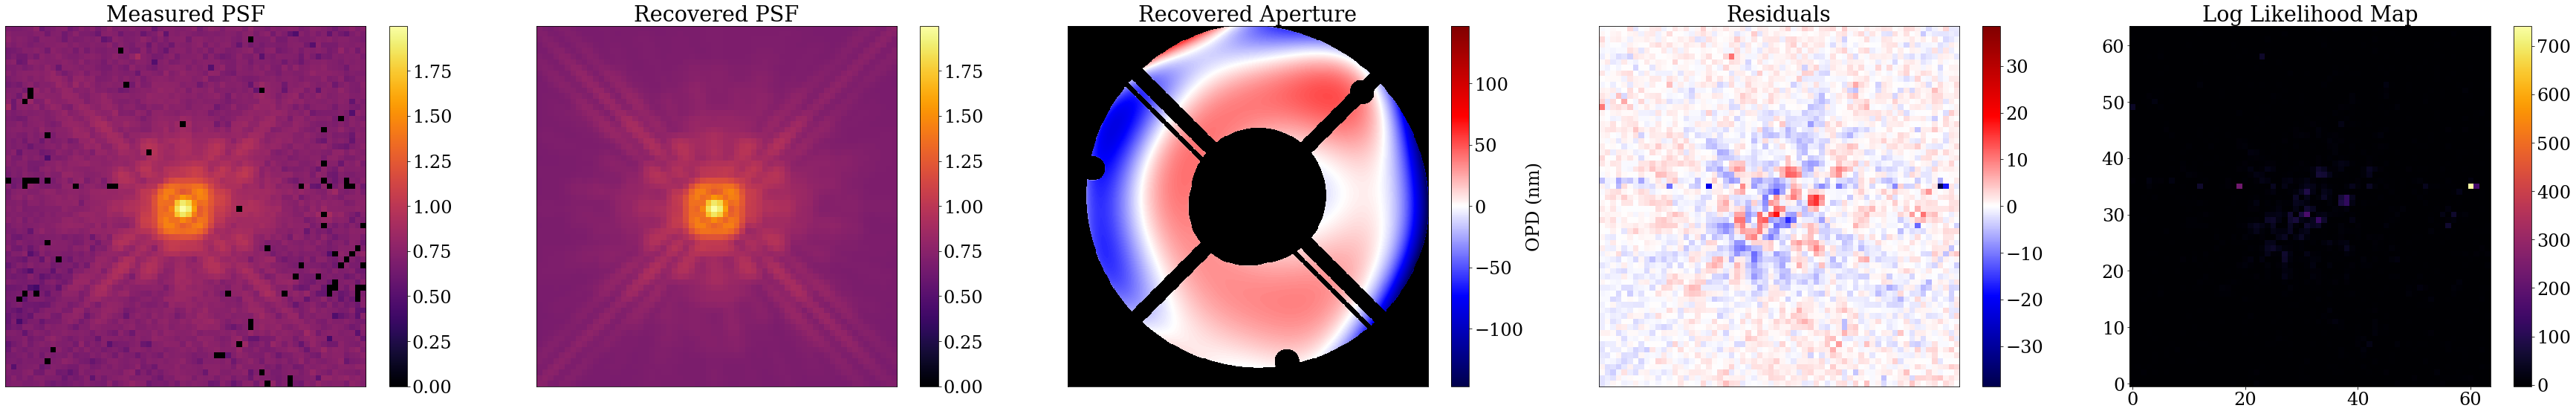

In [240]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)